In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import datetime


In [2]:
#,names=["state_code", "date", "value","state_name","latitude","longitude"]
df = pd.read_csv('/content/drive/MyDrive/bootcampdata/tmaxdata_avg_with_lat_long_monthly.csv',parse_dates=True)
df = df[df['state_code'] == 'CA']
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
df.drop(["state_code","state_name","latitude","longitude"],inplace=True,axis=1)
#df.groupby(by=[df.index.year,df.index.month]).agg("mean")
#df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M')
#df.info()
#df.groupby(["year_month"]).mean()
#df.groupby(pd.Grouper(freq='M', key='date')).mean()
#out = df.groupby(pd.to_datetime(df['dt']).dt.to_period('M')).mean()
#df = df.groupby([pd.to_datetime(df['date']).dt.strftime('%Y-%m')]).mean().reset_index()
#df.info()
#df.date = pd.to_datetime(df.date)
#df.info()
df.date = pd.to_datetime(df.date, format='%Y-%m')
df = df.set_index("date")
df

,value
date,
1905-01-01,24.677419
1905-02-01,24.717857
1905-03-01,28.764516
1905-04-01,31.403333
1905-05-01,34.574194
...,...
2022-04-01,35.860000
2022-05-01,39.429032
2022-06-01,45.350000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 1905-01-01 to 2022-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1412 non-null   float64
dtypes: float64(1)
memory usage: 22.1 KB


In [4]:
train, test = df[:-12], df[-12:]
train

,value
date,
1905-01-01,24.677419
1905-02-01,24.717857
1905-03-01,28.764516
1905-04-01,31.403333
1905-05-01,34.574194
...,...
2021-04-01,36.373333
2021-05-01,40.012903
2021-06-01,47.336667


In [5]:
test

,value
date,
2021-09-01,43.390000
2021-10-01,34.280645
2021-11-01,32.226667
2021-12-01,24.458065
2022-01-01,25.448387
2022-02-01,27.850000
2022-03-01,31.625806
2022-04-01,35.860000
2022-05-01,39.429032


In [6]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [7]:
train

array([[0.21353278],
       [0.21479126],
       [0.34072884],
       ...,
       [0.91871967],
       [0.95582773],
       [0.90864371]])

In [8]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [9]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
model.fit_generator(generator,epochs=90)


Epoch 1/90
232/232 [==============================] - 7s 19ms/step - loss: 0.0337
Epoch 2/90
232/232 [==============================] - 4s 19ms/step - loss: 0.0070
Epoch 3/90
232/232 [==============================] - 5s 20ms/step - loss: 0.0078
Epoch 4/90
232/232 [==============================] - 3s 13ms/step - loss: 0.0067
Epoch 5/90
232/232 [==============================] - 3s 11ms/step - loss: 0.0078
Epoch 6/90
232/232 [==============================] - 3s 11ms/step - loss: 0.0052
Epoch 7/90
232/232 [==============================] - 3s 12ms/step - loss: 0.0053
Epoch 8/90
232/232 [==============================] - 3s 11ms/step - loss: 0.0052
Epoch 9/90
232/232 [==============================] - 3s 12ms/step - loss: 0.0058
Epoch 10/90
232/232 [==============================] - 3s 11ms/step - loss: 0.0053
Epoch 11/90
232/232 [==============================] - 3s 11ms/step - loss: 0.0054
Epoch 12/90
232/232 [==============================] - 3s 11ms/step - loss: 0.0051
Epoch 13/90
2

In [11]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [12]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)

In [13]:
df_test

,value,Prediction
date,,
1905-01-01,24.677419,NaN
1905-02-01,24.717857,NaN
1905-03-01,28.764516,NaN
1905-04-01,31.403333,NaN
1905-05-01,34.574194,NaN
...,...,...
2022-04-01,35.860000,34.638545
2022-05-01,39.429032,40.252624
2022-06-01,45.350000,46.363602


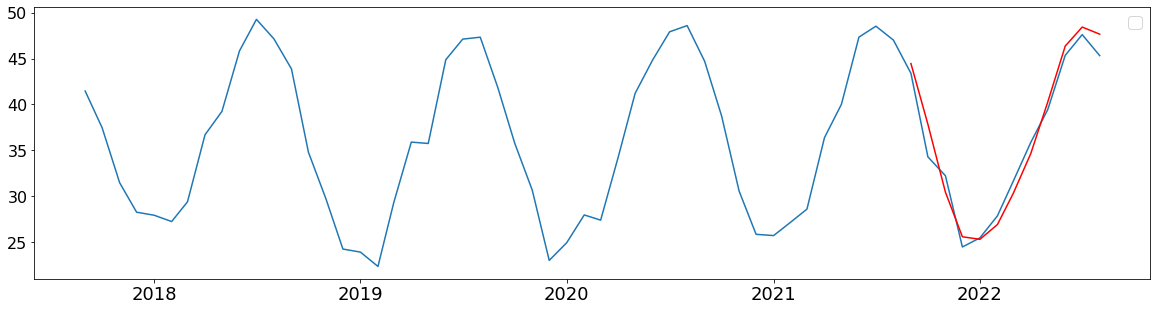

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index[-60:], df_test['value'][-60:])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [15]:
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [1.58723705]


In [16]:
train = df
train

,value
date,
1905-01-01,24.677419
1905-02-01,24.717857
1905-03-01,28.764516
1905-04-01,31.403333
1905-05-01,34.574194
...,...
2022-04-01,35.860000
2022-05-01,39.429032
2022-06-01,45.350000


In [17]:
scaler.fit(train)
train = scaler.transform(train)

In [18]:
len(train)

1412

In [19]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [20]:
model.fit_generator(generator,epochs=90)


Epoch 1/90
234/234 [==============================] - 3s 12ms/step - loss: 0.0035
Epoch 2/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0035
Epoch 3/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0035
Epoch 4/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0035
Epoch 5/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0033
Epoch 6/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0035
Epoch 7/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0034
Epoch 8/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0033
Epoch 9/90
234/234 [==============================] - 3s 11ms/step - loss: 0.0034
Epoch 10/90
234/234 [==============================] - 3s 12ms/step - loss: 0.0033
Epoch 11/90
234/234 [==============================] - 3s 12ms/step - loss: 0.0035
Epoch 12/90
234/234 [==============================] - 3s 12ms/step - loss: 0.0033
Epoch 13/90
2

In [21]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))



In [22]:
batch

array([[[0.79589399],
        [0.51239835],
        [0.44847572],
        [0.20670615],
        [0.23752635],
        [0.31226784],
        [0.42977613],
        [0.56155005],
        [0.67262323],
        [0.85689188],
        [0.92731653],
        [0.85590165]]])

In [23]:
pred_list

[]

In [24]:
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [25]:
df.index[-1]

Timestamp('2022-08-01 00:00:00')

In [26]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [27]:
pred_list

[array([0.7357162], dtype=float32),
 array([0.5215856], dtype=float32),
 array([0.36028022], dtype=float32),
 array([0.22667709], dtype=float32),
 array([0.24184507], dtype=float32),
 array([0.2920366], dtype=float32),
 array([0.4122107], dtype=float32),
 array([0.5328906], dtype=float32),
 array([0.6789386], dtype=float32),
 array([0.83499694], dtype=float32),
 array([0.9177697], dtype=float32),
 array([0.8667165], dtype=float32)]

In [28]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

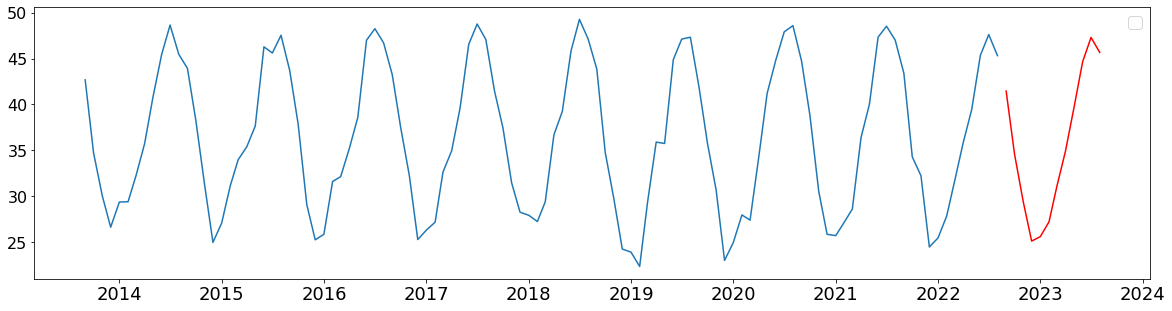

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index[-120:], df_proj['value'][-120:])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [30]:
df_proj

,value,Prediction
1905-01-01,24.677419,NaN
1905-02-01,24.717857,NaN
1905-03-01,28.764516,NaN
1905-04-01,31.403333,NaN
1905-05-01,34.574194,NaN
...,...,...
2023-04-01,NaN,34.939108
2023-05-01,NaN,39.631960
2023-06-01,NaN,44.646466
2023-07-01,NaN,47.306141


In [31]:
# df_proj['value'] = df_proj['value'].fillna(df_proj['Prediction'])

In [32]:
# df_proj.drop(["Prediction"],inplace=True,axis=1)

# df = df_proj

# df_proj = scaler.transform(df_proj)

In [33]:
# df_proj

In [34]:
# batch = df_proj[-n_input:].reshape((1, n_input, n_features))
# batch
# pred_list = []


In [35]:
# for i in range(n_input):   
#     pred_list.append(model.predict(batch)[0]) 
#     batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [36]:
# model.predict(batch)[0]

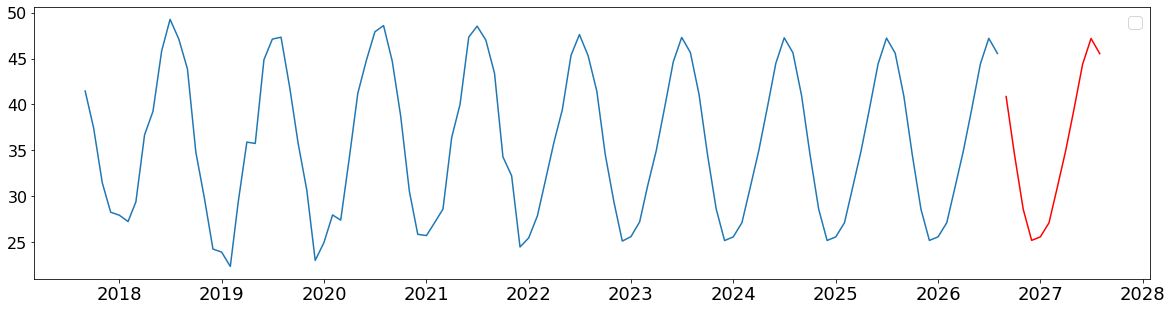

In [40]:
df_proj['value'] = df_proj['value'].fillna(df_proj['Prediction'])
df_proj.drop(["Prediction"],inplace=True,axis=1)
df = df_proj
df_proj = scaler.transform(df_proj)
pred_list = []
batch = df_proj[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])
df_proj = pd.concat([df,df_predict], axis=1)
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index[-120:], df_proj['value'][-120:])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()